# ICESat-2 ATL13 Product for Inland Water monitoring

This tutorial is developed for researchers interested in using the ATL13 product of the ICESat-2 for inland water monitoring e.g, lakes, rivers, reservoirs among others. In this tutorial, I have demonstrated how ATL13 product can be used for monitoring water surface height/elevation over time with a specific case study of Lake Victoria in the continent of Africa. With the tutorial, it is expected that the participants will achieve the following objectives:

1. Understanding the ICESat-2 ATL13 product and its usage in inland hydrology
2. Ability to access and extract required subset variables ATL13 data product
3. Participants would be able to create a water surface elevation dynamics

## Introduction to altimetry satellites 

Information about water surface height is important for effective water monitoring and management.The limited capability coverage of insitu data, remote sensing altimetry has proven to be useful for monitoring water surface height. The altimetry satellite monitor the time it takes the reflectnace to get to the satellite from the earth surface element observed. The monitoring of water surface height is represented with the Eq (1) 
                           
                           H=Alt−R+(DTC+WTC+IC+Ts)                 Eq.1

H=orthometric height, Alt= Altitude, R= Range, DTC= dry tropospheric,  WTC= tropospheric , IC=Ionospheric, Ts=Solid Tide (Calmant et al., 2008).

Represented below is a broader picture of how altimetry satellite monitors the surface water element.
![Svalbard](./altim.jpg)

Nielsen et al.  (2017)



The chart below illustrates the historical development of altimetry satellites for water surface height monitoring.
![Svalbard](./mussiom.JPG)
(Yekeen et al. 2023)

This product provides us with the ellipsoid height, orthometric height, wave height, latitude, longitude, time among others that will be used in this demonstration.

A Detail Explanation of the ATL13 Product

https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL13_data_dict_v003.pdf

### Import the important packages for downloading of ICESat-2 ATL13 product

In [ ]:
import icepyx as ipx
from pprint import pprint

## Lake Victoria in Central Africa 
![Svalbard](./studyarea.JPG)

#### Define the boundary of the inland water body or area extent of your study area. 
The lower left longitude and latitude in degree decimal follow by the Upper right longitude and latitude in degree decimal also.
(longitude, latitude, longitude, latitude)

The date interval needs to be specify as well. 


In [2]:
#Define CSA study area and type of data Lower left long,lat, upper right long, lat, you can also change the ATLs based on
#need, ATL06, ATL08, ATL03 ETC. e. Lake Victoria located between Uganda, Kneya and Tanzania
region_a = ipx.Query('ATL13', [ 31.966824, -1.833499, 33.875129, -0.495605], ['2018-10-01','2023-07-20'], \
                          start_time='00:00:00', end_time='23:59:59')
region_a.avail_granules()

{'Number of available granules': 303,
 'Average size of granules (MB)': 75.65766270955413,
 'Total size of all granules (MB)': 22924.27180099492}

This is to authentic if you are loggedin or not. To be able to do this, you need to have registered on Earthdata.

In [3]:
#Login
region_a.earthdata_login('user name','email') #change this to your earthdata username and password

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/07/2023


Now this will tell us the number of available granules that are present for the region and duration.

In [ ]:
#Show the different granules
region_a.order_granules()

In [5]:
#Download the data
region_a.download_granules('/tmp/Hydrology/')

Beginning download of zipped output...
Data request 5000004376012 of  1  order(s) is downloaded.
Download complete


### .........Now lets create dataframe from the downloaded ICESat-2
After Accessing the data, we are going to extract the data from all of the groundtracks. While some people would only be interested in the strong beams, because of the sizes of the lakes most especially the smallers ones, we might want to extract from all of the beams to have more observations. 


In [6]:
import h5py 
import numpy as np
import os
import re
import glob
import geopandas as gpd
from multiprocessing import Pool
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import convert_GPS_time as cGPS
from datetime import datetime
import matplotlib.dates as mdates

Here we will set our data path and use the glob packae to locate all the file with thesame starting and format.

In [7]:
# Directory containing the files
dir_path = '/home/jovyan/shared/ICESat-2-Hackweek/Hydrology/Lake Victoria/'

# List all files in the directory
file_list = glob.glob(os.path.join(dir_path, 'processed_ATL13*.h5'))

# List of all the subgroups containing the beams
sub_file_list = ['gt1l/', 'gt1r/', 'gt2l/', 'gt2r/', 'gt3l/', 'gt3r/']


Here we list the variables that we are interested in and save them into a dataframe.

In [8]:

# Loop through all the files
for file_path in file_list:
    # Open the file and read the data
    data = h5py.File(file_path, 'r')
    # Loop through all the subgroups and extract the data
    for subgroup in sub_file_list:
        if subgroup in data:
            lat = data.get(os.path.join(subgroup, 'segment_lat'))
            lon = data.get(os.path.join(subgroup, 'segment_lon'))
            height = data.get(os.path.join(subgroup, 'ht_ortho'))
            time = data.get(os.path.join(subgroup, 'delta_time'))
            qf_bc = data.get(os.path.join(subgroup, 'qf_bckgrd'))
            qf_bias = data.get(os.path.join(subgroup, 'qf_bias_em'))
            qf_fit = data.get(os.path.join(subgroup, 'qf_bias_fit'))
            swh = data.get(os.path.join(subgroup, 'significant_wave_ht'))
            std_ws = data.get(os.path.join(subgroup, 'stdev_water_surf'))
            
            #if all(x is not None for x in [ht_water,lat, lon, height, time]):

            if all(x is not None for x in [lat, lon, height, time, qf_bc, qf_bias, qf_fit, swh, std_ws]):
                df = pd.DataFrame(data={
                    'lat': lat[:],
                    'lon': lon[:],
                    'height': height[:],             
                    'time': time[:],
                    'qf_bc': qf_bc[:],
                    'qf_bias': qf_bias[:],
                    'qf_fit': qf_fit[:],
                    'swh': swh[:],
                    'std_ws' :std_ws[:]
                })
                # Add a column for the subgroup ID
                df['subgroup'] = subgroup
                # Concatenate the dataframes
                if 'combined_data' not in locals():
                    combined_data = df
                else:
                    combined_data = pd.concat([combined_data, df])
    # Close the file
    data.close()


In [9]:
#save the dataframe as a csv file
combined_data.to_csv('/tmp/Hydrology/combined_data1.csv', index=True)

In [10]:
#Import the csv file 
combined_data=pd.read_csv("/home/jovyan/shared/ICESat-2-Hackweek/Hydrology/Lake Victoria/combined_data1.csv") 

/tmp/ipykernel_551/3823291238.py:2: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data=pd.read_csv("/home/jovyan/shared/ICESat-2-Hackweek/Hydrology/Lake Victoria/combined_data1.csv")


In [11]:
All_lakes=combined_data

Because the granules are always longer than the study boundary, it is important to have a water mask to prevent the interaction of water and land. In this stage, we are importing the lake area mask to extract only observations that are water surface without contamination with land.

In [12]:
#import the shapefile of the lakes
Lake1 = gpd.read_file('/home/jovyan/shared/ICESat-2-Hackweek/Hydrology/lake_victoria.shp')

![Svalbard](./Lakevic.JPG)

In [13]:
# extract the data from the entire data
def filter_data_by_polygon(df, polygon_geo_df):
    df['geometry'] = gpd.points_from_xy(df['lon'], df['lat'])
    filtered_data = df[gpd.GeoDataFrame(df, geometry='geometry').within(polygon_geo_df.unary_union)]
    filtered_data = filtered_data.drop('geometry', axis=1)
    return filtered_data

Extract the required data 

In [14]:
filtered_csv1 = filter_data_by_polygon(All_lakes, Lake1)

In [15]:
Lake_Victoria=filtered_csv1 

The time is currently in the GPS format so with this code we will convert them to the Julian Day, Month and year

In [16]:
run -i convert_delta_time.py

In [17]:
temp = cGPS.convert_GPS_time(1.198800e+09 + Lake_Victoria.time, OFFSET=0.0)
year = temp['year'][:].astype('int')
month = temp['month'][:].astype('int')
day = temp['day'][:].astype('int')
hour = temp['hour'][:].astype('int')
minute = temp['minute'][:].astype('int')
second = temp['second'][:].astype('int')
    #time=temp[year: 'year',month:'month' ,day: 'day' ][:].astype('int')
year=np.c_[year]
month=np.c_[month]
day=np.c_[day]
Lake_Victoria['Year'] =year
Lake_Victoria['Month'] =month
Lake_Victoria['Day'] =day
Lake_Victoria['Time']=pd.to_datetime(Lake_Victoria['Year'].astype('str') + '-' + Lake_Victoria['Month'].astype('str')  + '-' + Lake_Victoria['Day'].astype('str'), yearfirst=True)

In [18]:
Lake_Victoria

Unnamed: 0   ht_water       lat        lon     height          time  \
16              18  1117.5900 -0.602123  33.870005  1135.1748  2.531880e+07   
17              19  1117.6124 -0.605284  33.869687  1135.1996  2.531880e+07   
18              20  1117.5864 -0.607841  33.869432  1135.1753  2.531880e+07   
19              21  1117.6119 -0.609506  33.869264  1135.2020  2.531880e+07   
20              22  1117.6145 -0.611254  33.869092  1135.2058  2.531880e+07   
...            ...        ...       ...        ...        ...           ...   
811934          82        NaN -0.685979  33.668160  1135.7320  1.640605e+08   
811935          83        NaN -0.686397  33.668122  1135.7255  1.640605e+08   
811936          84        NaN -0.687562  33.668015  1135.7468  1.640605e+08   
811937          85        NaN -0.692744  33.667544  1135.7163  1.640605e+08   
811938          86        NaN -0.758830  33.660830  1135.6062  1.640605e+08   

        ice_flag  qf_bc  snow_ice  qf_bias  ...   swh  l_layer  std_ws  \
16         127.0      1       0.0        0  ...  0.26      1.0   0.065   
17         127.0      1       0.0        0  ...  0.26      1.0   0.065   
18         127.0      1       0.0        0  ...  0.26      1.0   0.065   
19         127.0      1       0.0        0  ...  0.04      1.0   0.010   
20         127.0      1       0.0        0  ...  0.04      1.0   0.010   
...          ...    ...       ...      ...  ...   ...      ...     ...   
811934       NaN      0       NaN        0  ...  0.44      NaN   0.110   
811935       NaN      0       NaN        0  ...  0.44      NaN   0.110   
811936       NaN      0       NaN        0  ...  0.44      NaN   0.110   
811937       NaN      0       NaN        0  ...  0.44      NaN   0.110   
811938       NaN      0       NaN        0  ...  0.44      NaN   0.110   

            s_bf       w_d  subgroup  Year  Month Day       Time  
16      0.000346  3.468284     gt1l/  2018     10  21 2018-10-21  
17      0.000346  3.468284     gt1l/  2018     10  21 2018-10-21  
18      0.000346  3.468284     gt1l/  2018     10  21 2018-10-21  
19      0.021160  3.774847     gt1l/  2018     10  21 2018-10-21  
20      0.021160  3.774847     gt1l/  2018     10  21 2018-10-21  
...          ...       ...       ...   ...    ...  ..        ...  
811934       NaN       NaN     gt3l/  2023      3  14 2023-03-14  
811935       NaN       NaN     gt3l/  2023      3  14 2023-03-14  
811936       NaN       NaN     gt3l/  2023      3  14 2023-03-14  
811937       NaN       NaN     gt3l/  2023      3  14 2023-03-14  
811938       NaN       NaN     gt3l/  2023      3  14 2023-03-14  

[630815 rows x 23 columns]

In [19]:
Lake_Victoria=Lake_Victoria.drop(columns=['Year', 'Month', 'Day'])

In [20]:
#All_lakes=All_lakes[(All_lakes.snow_ice < 2) & All_lakes.l_layer < 0) & (All_lakes.qf_bc < 6) & (All_lakes.qf_bias +- 2) & (All_lakes.qf_fit +- 2) & (All_lakes.std_ws < 2)]

In [21]:
All_lakes=Lake_Victoria

Due to the combinations of the different beams and the other atmspheric effect, outlier are expected to be present in the data. To remove this, we use the inter-quartile range method to remove the outliers from the data

In [22]:
run -i outlier_removal.py

In [23]:
lowerbound,upperbound = outlier_treatment(All_lakes.height)
All_lakes[(All_lakes.height < lowerbound) | (All_lakes.height > upperbound)]
All_lakes.drop(All_lakes[ (All_lakes.height > upperbound) | (All_lakes.height < lowerbound) ].index , inplace=True)

In [24]:
All_lakes

Unnamed: 0   ht_water       lat        lon     height          time  \
16              18  1117.5900 -0.602123  33.870005  1135.1748  2.531880e+07   
17              19  1117.6124 -0.605284  33.869687  1135.1996  2.531880e+07   
18              20  1117.5864 -0.607841  33.869432  1135.1753  2.531880e+07   
19              21  1117.6119 -0.609506  33.869264  1135.2020  2.531880e+07   
20              22  1117.6145 -0.611254  33.869092  1135.2058  2.531880e+07   
...            ...        ...       ...        ...        ...           ...   
811934          82        NaN -0.685979  33.668160  1135.7320  1.640605e+08   
811935          83        NaN -0.686397  33.668122  1135.7255  1.640605e+08   
811936          84        NaN -0.687562  33.668015  1135.7468  1.640605e+08   
811937          85        NaN -0.692744  33.667544  1135.7163  1.640605e+08   
811938          86        NaN -0.758830  33.660830  1135.6062  1.640605e+08   

        ice_flag  qf_bc  snow_ice  qf_bias  qf_fit  flag_asr  flag_atm   swh  \
16         127.0      1       0.0        0       0       5.0       3.0  0.26   
17         127.0      1       0.0        0       0       5.0       3.0  0.26   
18         127.0      1       0.0        0       0       5.0       3.0  0.26   
19         127.0      1       0.0        0       1       5.0       3.0  0.04   
20         127.0      1       0.0        0       1       5.0       3.0  0.04   
...          ...    ...       ...      ...     ...       ...       ...   ...   
811934       NaN      0       NaN        0       0       NaN       NaN  0.44   
811935       NaN      0       NaN        0       0       NaN       NaN  0.44   
811936       NaN      0       NaN        0       0       NaN       NaN  0.44   
811937       NaN      0       NaN        0       0       NaN       NaN  0.44   
811938       NaN      0       NaN        0       0       NaN       NaN  0.44   

        l_layer  std_ws      s_bf       w_d subgroup       Time  
16          1.0   0.065  0.000346  3.468284    gt1l/ 2018-10-21  
17          1.0   0.065  0.000346  3.468284    gt1l/ 2018-10-21  
18          1.0   0.065  0.000346  3.468284    gt1l/ 2018-10-21  
19          1.0   0.010  0.021160  3.774847    gt1l/ 2018-10-21  
20          1.0   0.010  0.021160  3.774847    gt1l/ 2018-10-21  
...         ...     ...       ...       ...      ...        ...  
811934      NaN   0.110       NaN       NaN    gt3l/ 2023-03-14  
811935      NaN   0.110       NaN       NaN    gt3l/ 2023-03-14  
811936      NaN   0.110       NaN       NaN    gt3l/ 2023-03-14  
811937      NaN   0.110       NaN       NaN    gt3l/ 2023-03-14  
811938      NaN   0.110       NaN       NaN    gt3l/ 2023-03-14  

[630814 rows x 20 columns]

Here we will calculate the daily mean and adopt it as our water level height while we also adopt its standard devaition as the spatial uncertainty.

In [25]:
All_lakes=All_lakes.groupby('Time')
All_lakes=All_lakes['height'].agg(['mean', 'std'])

In [26]:
All_lakes

mean       std
Time                             
2018-10-21  1135.044146  0.075003
2018-11-06  1135.195079  0.173076
2018-11-22  1134.910300       NaN
2018-12-13  1135.074087  0.105894
2018-12-21  1134.913000       NaN
...                 ...       ...
2023-01-28  1135.976530  0.102157
2023-02-13  1135.607841  0.118052
2023-02-26  1135.588323  0.123084
2023-03-06  1135.420421  0.119426
2023-03-14  1135.696764  0.150969

[85 rows x 2 columns]

In [27]:
merged_L12_2=All_lakes

Using the matplot library we will plot the water height. Before that we will make sure that the date is sorted.

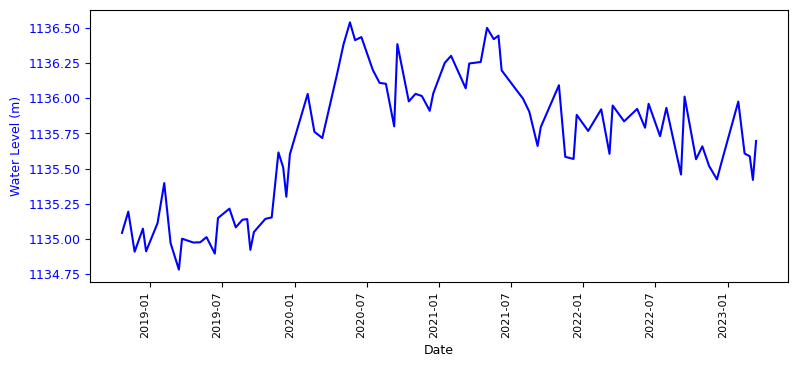

In [28]:
merged_L12_2.sort_index()

fig, ax1 = plt.subplots(figsize=(9,4))

# plot precipitation as vertical lines
ax1.plot(merged_L12_2['mean'], color='blue')

# set x-axis label
ax1.set_xlabel('Date', fontsize=9)
ax1.tick_params('x', colors='black', labelsize=8)
fig.autofmt_xdate(rotation=90)

# set y-axis label for precipitation
ax1.set_ylabel('Water Level (m)', color='blue', fontsize=9)
ax1.tick_params('y', colors='blue', labelsize=9)
plt.show()


Here we will plot the height and the uncertainty of each height

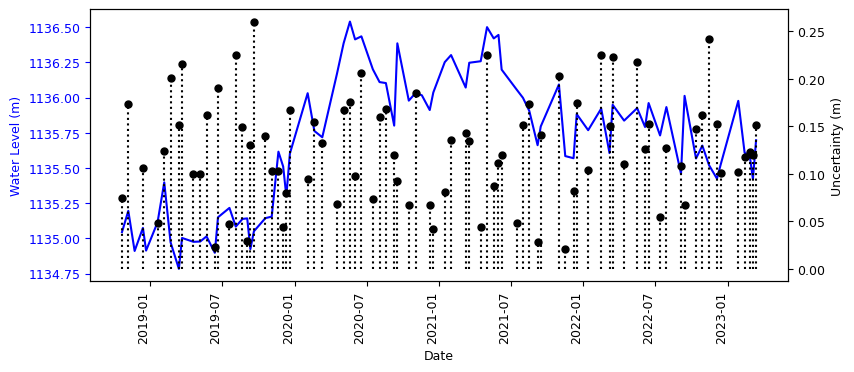

In [29]:
#create the uncertainty graph

merged_L12_2.sort_index()

fig, ax1 = plt.subplots(figsize=(9,4))

# plot precipitation as vertical lines
ax1.plot(merged_L12_2['mean'], color='blue')

# set x-axis label
ax1.set_xlabel('Date', fontsize=9)
ax1.tick_params('x', colors='black', labelsize=9)
fig.autofmt_xdate(rotation=90)

# set y-axis label for precipitation
ax1.set_ylabel('Water Level (m)', color='blue', fontsize=9)
ax1.tick_params('y', colors='blue', labelsize=9)

# create a twin axis for stage data
ax2 = ax1.twinx()

# plot stage data as a line
ax2.vlines(merged_L12_2.index, 0, merged_L12_2['std'], colors='black', alpha=1, linestyle=':')
ax2.plot(merged_L12_2.index, merged_L12_2['std'], color='black', alpha=1, linestyle=' ', marker='o', markersize=5)

# set y-axis label for stage data
ax2.set_ylabel('Uncertainty (m)', color='black', fontsize=9)
ax2.tick_params('y', colors='black',labelsize=9)

# set title for the plot
#plt.title('Lake HC_16   Water Level Vs Precipitation', fontsize=18)

# show grid lines
#plt.grid(True)

plt.show()

using the linear regression fitting line, we will determine the annual variation of the water level

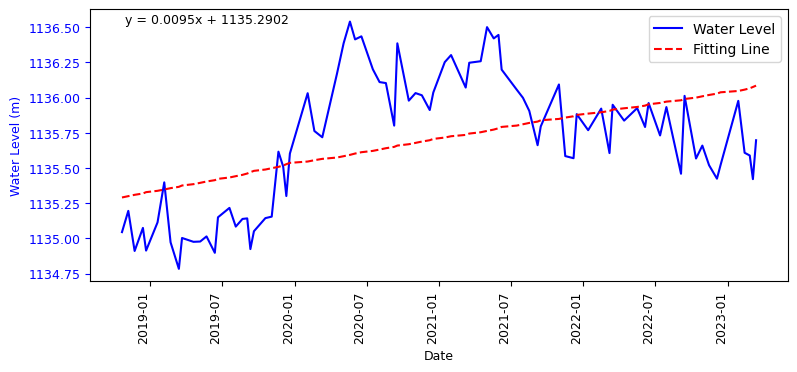

In [30]:
# Sort the DataFrame by date in ascending order
merged_L12_2.sort_index(inplace=True)

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot water level as a line
ax1.plot(merged_L12_2['mean'], color='blue', label='Water Level')

# Calculate linear regression coefficients (slope and intercept)
fit_coeffs = np.polyfit(range(len(merged_L12_2)), merged_L12_2['mean'], 1)
fit_line = np.poly1d(fit_coeffs)

fit_line_x = np.array([0, len(merged_L12_2) - 1])
fit_line_y = fit_line(fit_line_x)

# Plot the fitting line
ax1.plot(merged_L12_2.index, fit_line(range(len(merged_L12_2))), color='red', linestyle='--', label='Fitting Line')

# Set x-axis label and rotate date labels
ax1.set_xlabel('Date', fontsize=9)
ax1.tick_params('x', colors='black', labelsize=9)
fig.autofmt_xdate(rotation=90)

# Set y-axis label for water level
ax1.set_ylabel('Water Level (m)', color='blue', fontsize=9)
ax1.tick_params('y', colors='blue', labelsize=9)

# Display the linear regression equation
equation_text = f'y = {fit_coeffs[0]:.4f}x + {fit_coeffs[1]:.4f}'
ax1.text(0.05, 0.95, equation_text, transform=ax1.transAxes, fontsize=9)

# Show legend
ax1.legend()

# Show the plot
plt.show()

Thanks for following along.  

### References
Calmant, S., Seyler, F., & Cretaux, J. F. (2008). Monitoring Continental Surface Waters by Satellite Altimetry. Surveys in Geophysics, 29(4), 247–269. https://doi.org/10.1007/s10712-008-9051-1

Nielsen, K.; Stenseng, L.; Andersen, O.B.; Knudsen, P. The Performance and Potentials of the CryoSat-2 SAR and SARIn Modes for Lake Level Estimation. Water 2017, 9, 374. https://doi.org/10.3390/w9060374

Shamsudeen Yekeen, Ben DeVries, Aaron Berg, Rosy Tutton , Branden Walker, Jackson Seto, Philip Marsh. (2023) Operational Methodology for the Monitoring of Canadian Arctic Lakes Water Surface Elevation (WSE) Dynamics Using  Gauges, ICESat-2 and Sentinel-3 Data: In Preparation for SWOT Altimetry Data: 44th Canadian Symposium on Remote Sensing /44e Symposium canadien de télédétection



